In [1]:
from sh import wget, tar

# Download data
wget("https://s3.amazonaws.com/fast-ai-sample/planet_tiny.tgz")
# Untar
tar("-xf", "planet_tiny.tgz")

In [2]:
import pathlib
import numpy as np 
from embetter.grab import ImageGrabber
from PIL import Image

image_paths = list(pathlib.Path("planet_tiny/train").glob("*.jpg"))
images = [Image.open(x).convert('RGB') for x in image_paths]

In [3]:
X = np.array([np.array(i) for i in images])
n_buckets = 5

output = np.zeros((len(X), n_buckets * 3))
output.shape
for i, x in enumerate(images):
    arr = np.array(x)
    output[i, :] = np.concatenate(
        [
            np.histogram(
                arr[:, :, 0].flatten(), bins=np.linspace(0, 255, n_buckets + 1)
            )[0],
            np.histogram(
                arr[:, :, 1].flatten(), bins=np.linspace(0, 255, n_buckets + 1)
            )[0],
            np.histogram(
                arr[:, :, 2].flatten(), bins=np.linspace(0, 255, n_buckets + 1)
            )[0],
        ]
    )

/home/vincent/Development/cluestar/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-25 15:37:16.283844: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 15:37:16.283873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


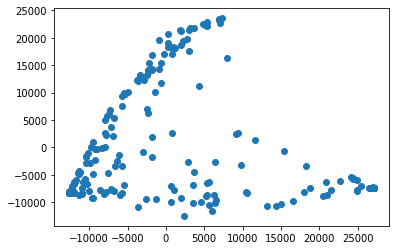

In [4]:
from umap import UMAP 
from sklearn.decomposition import PCA

# UMAP is actually a bit worse here. 
# X_tfm = UMAP().fit_transform(output)
X_tfm = PCA().fit_transform(output)

import matplotlib.pylab as plt 
plt.scatter(X_tfm[:, 0], X_tfm[:, 1])

In [5]:
import io
import base64
from PIL import Image

base64_imgs = []

for path in image_paths:
    image = Image.open(path)
    output = io.BytesIO()    
    image.save(output, format='JPEG')
    encoded_string = "data:image/jpeg;base64,"+ base64.b64encode(output.getvalue()).decode()
    base64_imgs.append(encoded_string)

alt.HConcatChart(...)
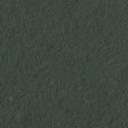
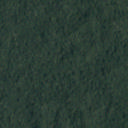
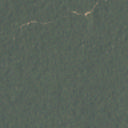
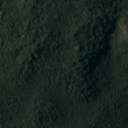
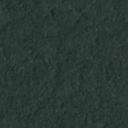
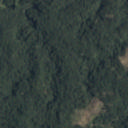
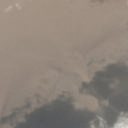
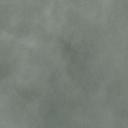
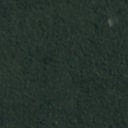
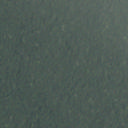
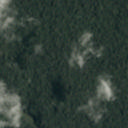
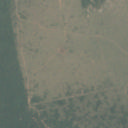
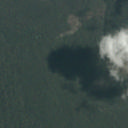
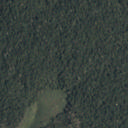
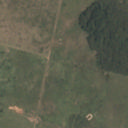
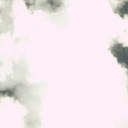
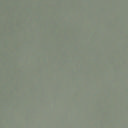
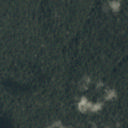
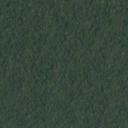
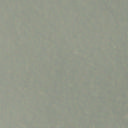
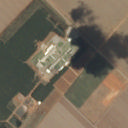
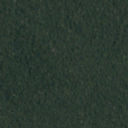
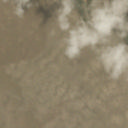
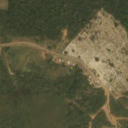
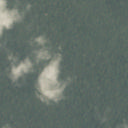
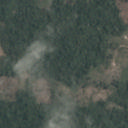
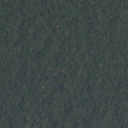
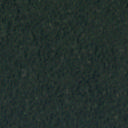
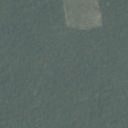
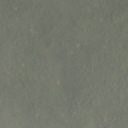
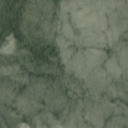
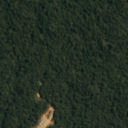
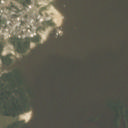
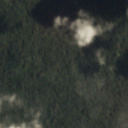
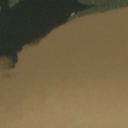
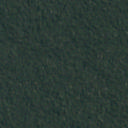
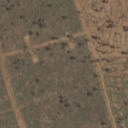
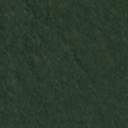
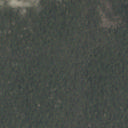
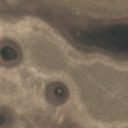
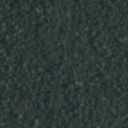
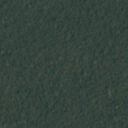
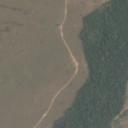
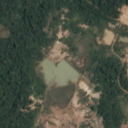
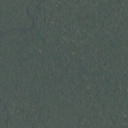
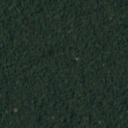
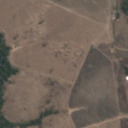
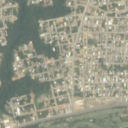
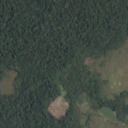
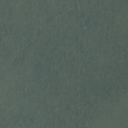
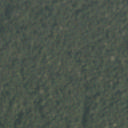
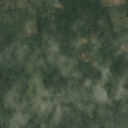
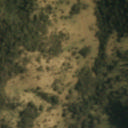
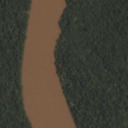
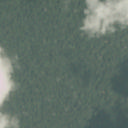
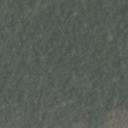
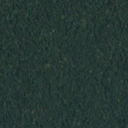
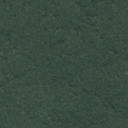
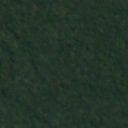
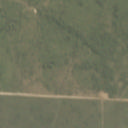
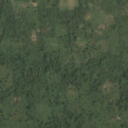
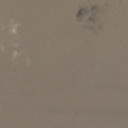
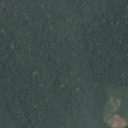
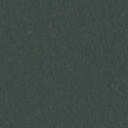
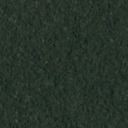
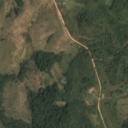
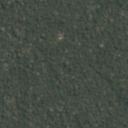
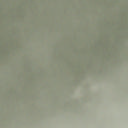
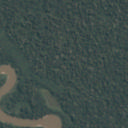
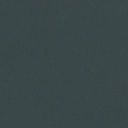
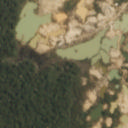
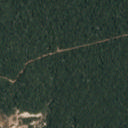
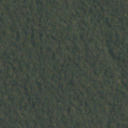
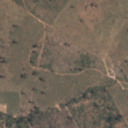
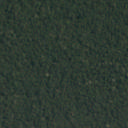
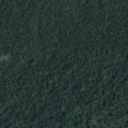
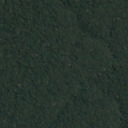
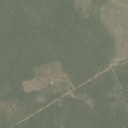
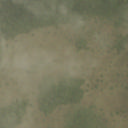
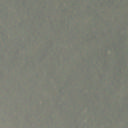
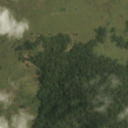
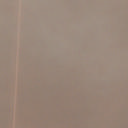
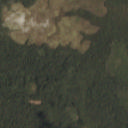
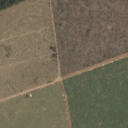
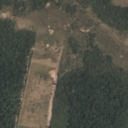
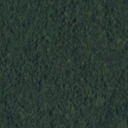
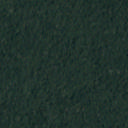
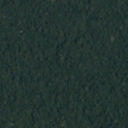
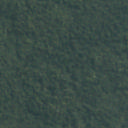
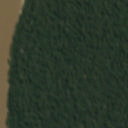
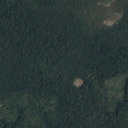
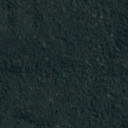
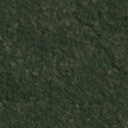
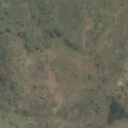
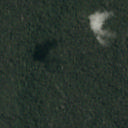
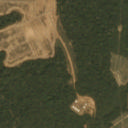
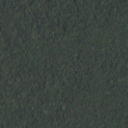
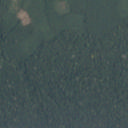
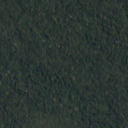
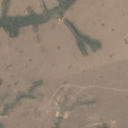
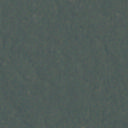
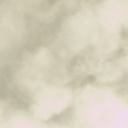
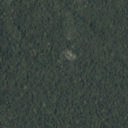
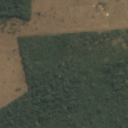
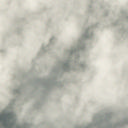
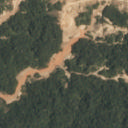
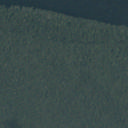
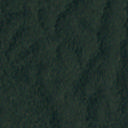
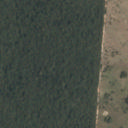
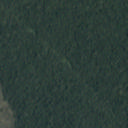
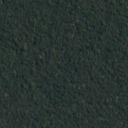
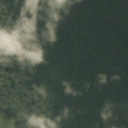
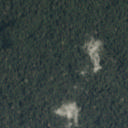
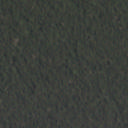
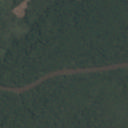
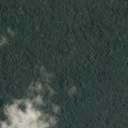
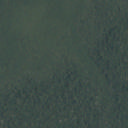
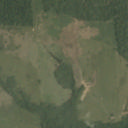
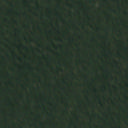
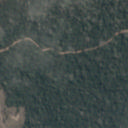
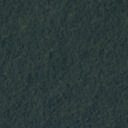
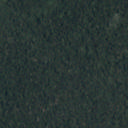
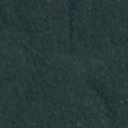
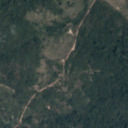
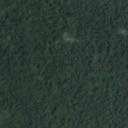
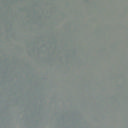
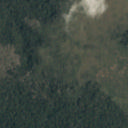
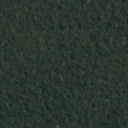
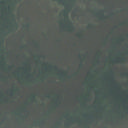
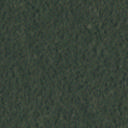
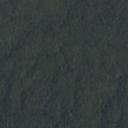
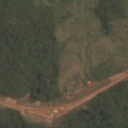
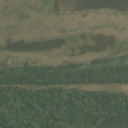
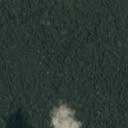
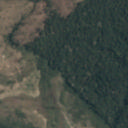
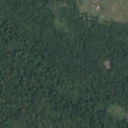
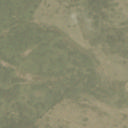
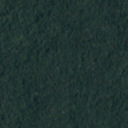
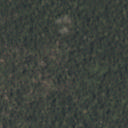
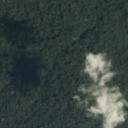
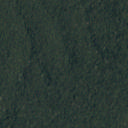
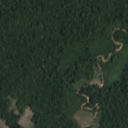
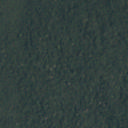
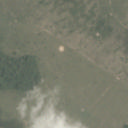
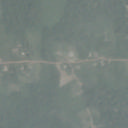
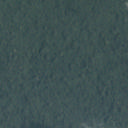
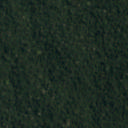
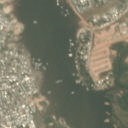
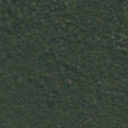
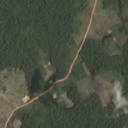
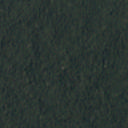
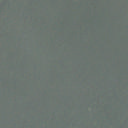
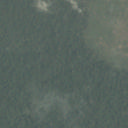
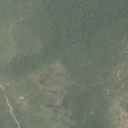
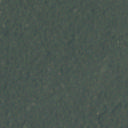
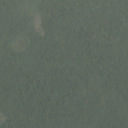
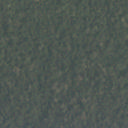
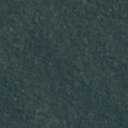
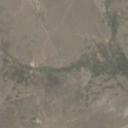
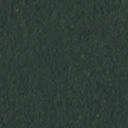
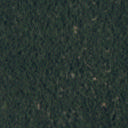
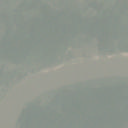
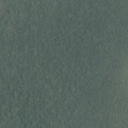
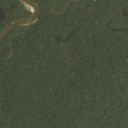
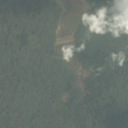
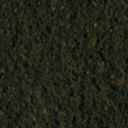
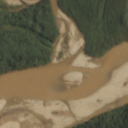
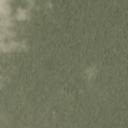
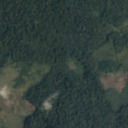
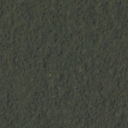
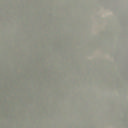
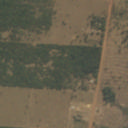
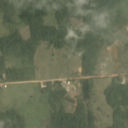
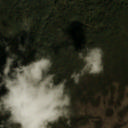
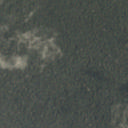
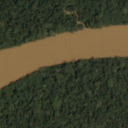
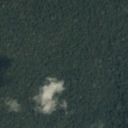
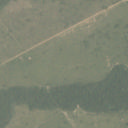
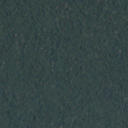
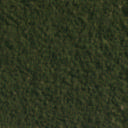
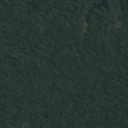
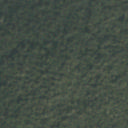
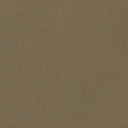
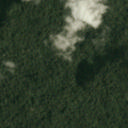
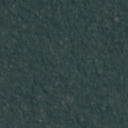
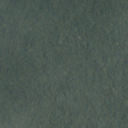
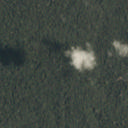
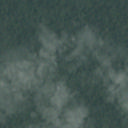
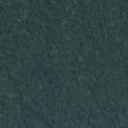
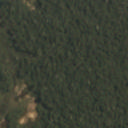
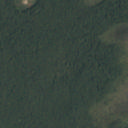
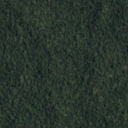
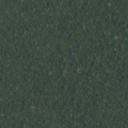
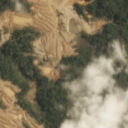
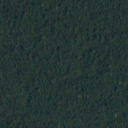
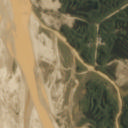
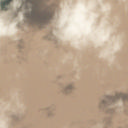
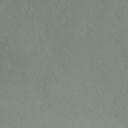
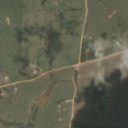
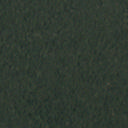

In [7]:
import altair as alt 
import pandas as pd

df_ = pd.DataFrame({"x1": X_tfm[:, 0], "x2": X_tfm[:, 1], "image": base64_imgs})

brush = alt.selection(type="interval")

p1 = (
    alt.Chart(df_)
    .mark_circle(opacity=0.6, size=50)
    .encode(
        x=alt.X("x1", axis=None, scale=alt.Scale(zero=False)),
        y=alt.Y("x2", axis=None, scale=alt.Scale(zero=False)),
        tooltip=["image"],
    )
    .properties(width=350, height=350, title="embedding space")
    .add_selection(brush)
)

p2 = (
    alt.Chart(df_)
    .mark_image(opacity=0.9, size=50, width=50, height=50)
    .encode(
        x=alt.X("x1", axis=None, scale=alt.Scale(zero=False)),
        y=alt.Y("x2", axis=None, scale=alt.Scale(zero=False)),
        url="image",
    )
    .transform_filter(brush)
    .properties(width=350, height=350, title="embedding space")
    .interactive()
)
p1 | p2